# HW05: Practice with algorithm selection, assessment, hyperparameter tuning, multiclass and one-class classification, and imbalanced data.

[Abdifatah Abdi, aaabdi2@wisc.edu]

##### Hello Students:
 Start by downloading HW05.ipynb from this folder. Then develop it into your solution.
- Write code where you see "... your code here ..." below.
  (You are welcome to use more than one cell.)
- If you have questions, please ask them in class or office hours. Our TA
  and I are very happy to help with the programming (provided you start early
  enough, and provided we are not helping so much that we undermine your learning).
- When you are done, run these Notebook commands:
  - Shift-L (once, so that line numbers are visible)
  - Kernel > Restart and Run All (run all cells from scratch)
  - Esc S (save)
  - File > Download as > HTML
- Turn in HW05.ipynb and HW05.html to Canvas's HW05 assignment

  As a check, download your files from Canvas to a new 'junk' folder. Try 'Kernel > Restart
  and Run All' on the '.ipynb' file to make sure it works. Glance through the '.html' file.
- Turn in partial solutions to Canvas before the deadline. e.g. Turn in part 1,
  then parts 1 and 2, then your whole solution. That way we can award partial credit
  even if you miss the deadline. We will grade your last submission before the deadline.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import mixture

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             accuracy_score, roc_auc_score, RocCurveDisplay)

from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler

## 1. Algorithm selection for multiclass classification by optical recognition of handwritten digits

The [digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) dataset
  has 1797 labeled images of hand-written digits.
  - $X$ = `digits.data` has shape (1797, 64).
    - Each image $\mathbf{x}_i$ is represented as the $i$th row of 64 pixel values in the 2D
      `digits.data` array that corresponds to an 8x8 photo of a handwritten digit.
  - $y$ = `digits.target` has shape (1797,). Each $y_i$ is a number from 0 to 9 indicating
    the handwritten digit that was photographed and stored in $\mathbf{x}_i$.



### 1(a) Load the digits dataset and split it into training, validation, and test sets as I did in the lecture example code [07ensemble.html](https://pages.stat.wisc.edu/~jgillett/451/burkov/07/07ensemble.html).
This step does not need to display any output.

In [14]:
# ... your code here ...

# Load the digits dataset
digits = datasets.load_digits()
X = digits.data  # Shape: (1797, 64), each row is an 8x8 image
y = digits.target  # Shape: (1797,), each value is a digit (0-9)

# Display dataset shape to confirm loading
print("Shape of X (features):", X.shape)
print("Shape of y (target):", y.shape)

# split 80% training data, 20% "_tmp" for validation & test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2,
                                                  random_state=0, stratify=y)
# of remaining 20%, split in half to get 10% validation, 10% test
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,
  random_state=0, stratify=y_tmp)


# Display the shapes of the splits to confirm
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_valid.shape, y_valid.shape)
print("Test set shape:", X_test.shape, y_test.shape)



Shape of X (features): (1797, 64)
Shape of y (target): (1797,)
Training set shape: (1437, 64) (1437,)
Validation set shape: (180, 64) (180,)
Test set shape: (180, 64) (180,)


## 1(b) Use algorithm selection on training and validation data to choose a best classifier.
Loop through these four classifiers and corresponding parameters, doing a grid search
to find the best hyperparameter setting. Use only the training data for the grid search.
- SVM:
  - Try all values of `kernel` in 'linear', 'rbf'.
  - Try all values of `C` in 0.01, 1, 100.
- logistic regression:
  - Use `max_iter=5000` to avoid a nonconvergence warning.
  - Try all values of `C` in 0.01, 1, 100.
- ID3 decision tree:
  - Use `criterion='entropy` to get our ID3 tree.
  - Try all values of `max_depth` in 1, 3, 5, 7.
- kNN:
  - (Use the default Euclidean distance).
  - Try all values of `n_neighbors` in 1, 2, 3, 4.

Hint:
- Make a list of the four classifiers without setting any hyperparameters.
- Make a list of four corresponding parameter dictionaries.
- Loop through 0, 1, 2, 3:
  - Run grid search on the $i$th classifier with the $i$th parameter dictionary on the
    training data. (The grid search does its own cross-validation using the training data.)
  - Use the $i$th classifier with its best hyperparameter settings (just `clf` from
    `clf = GridSearchCV(...)`) to find the accuracy of the model on the validation data, i.e.
    find `clf.score(X_valid, y_valid)`.
- Keep track, as your loop progresses, of:
  - the index $i$ of the best classifier (initialize it to `-1` or some other value)
  - the best accuracy score on validation data (initialize it to `-np.Inf`)
  - the best classifier with its hyperparameter settings, that is the best `clf` from
    `clf = GridSearchCV(...)` (initialize it to `None` or some other value)

I needed about 30 lines of code to do this. It took a minute to run.

In [18]:
# ... your code here ...


# Define classifiers and parameter grids
classifiers = [
    svm.SVC(),
    linear_model.LogisticRegression(max_iter=5000),
    DecisionTreeClassifier(criterion='entropy'),
    KNeighborsClassifier()
]

param_grids = [
    {'kernel': ['linear', 'rbf'], 'C': [0.01, 1, 100]},  # SVM
    {'C': [0.01, 1, 100]},  # Logistic Regression
    {'max_depth': [1, 3, 5, 7]},  # Decision Tree
    {'n_neighbors': [1, 2, 3, 4]}  # kNN
]

# Perform grid search
results = []
best_clf = None
best_score = -np.inf

for clf, params in zip(classifiers, param_grids):
    grid_search = GridSearchCV(clf, params, cv=5)
    grid_search.fit(X_train, y_train)

    # Evaluate on validation data
    val_score = grid_search.score(X_valid, y_valid)
    results.append((type(clf).__name__, val_score, grid_search.best_params_))

    # Track the best model
    if val_score > best_score:
        best_score = val_score
        best_clf = grid_search

# Print results
print("Classifier results and best parameters:")
for result in results:
    print(f"{result[0]} achieved a validation accuracy of {result[1]:.3f} with hyperparameters: {result[2]}.")

print(f"\nThe best model is {type(best_clf.best_estimator_).__name__} with a validation accuracy of {best_score:.3f}.")




    

Classifier results and best parameters:
SVC achieved a validation accuracy of 0.989 with hyperparameters: {'C': 1, 'kernel': 'rbf'}.
LogisticRegression achieved a validation accuracy of 0.972 with hyperparameters: {'C': 0.01}.
DecisionTreeClassifier achieved a validation accuracy of 0.844 with hyperparameters: {'max_depth': 7}.
KNeighborsClassifier achieved a validation accuracy of 0.989 with hyperparameters: {'n_neighbors': 3}.

The best model is SVC with a validation accuracy of 0.989.


### 1(c) Use the test data to evaluate your already-fit best classifier and its hyperparameter settings from 1(b).
- Well, there are two tied for 'best'. Please use the first of these two.
- Report the result of calling `.score(X_test, y_test)` on your best classifier/hyperparameters.
- Show a confusion matrix from the true `y_test` values and the corresponding $\hat{y}$ values
  predicted by your best classifier/hyperparameters on `X_test`.
- For each of the wrong predictions (where `y_test` and your $\hat{y}$ values disagree), show:
  - The index $i$ in the test data of that example $\mathbf{x}$
  - The correct label $y_i$
  - Your incorrect prediction $\hat{y}_i$
  - A plot of that image (to see whether the confusion was reasonable)

The best model's test accuracy is: 0.978
Confusion Matrix:
[[18  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  1  0  0]
 [ 0  0  0  0 17  0  0  0  1  0]
 [ 0  0  0  0  0 18  0  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0]
 [ 0  0  0  0  0  0  0 18  0  0]
 [ 0  1  0  0  0  0  0  0 16  0]
 [ 0  0  0  0  0  1  0  0  0 17]]


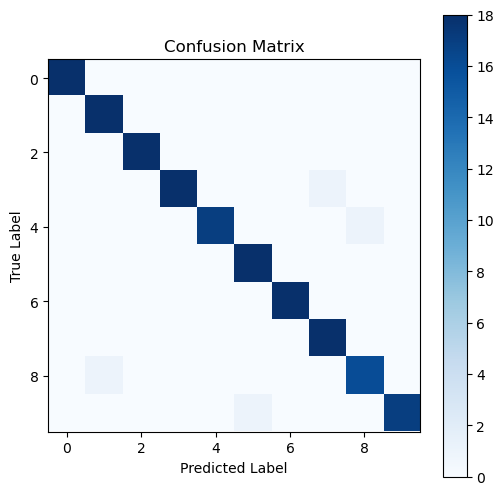

Number of incorrect predictions: 4
Index: 61, Actual Label: 9, Predicted Label: 5


<Figure size 640x480 with 0 Axes>

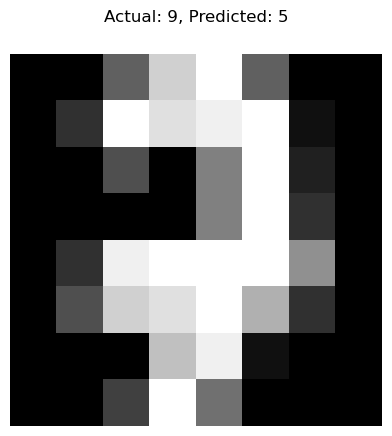

Index: 65, Actual Label: 4, Predicted Label: 8


<Figure size 640x480 with 0 Axes>

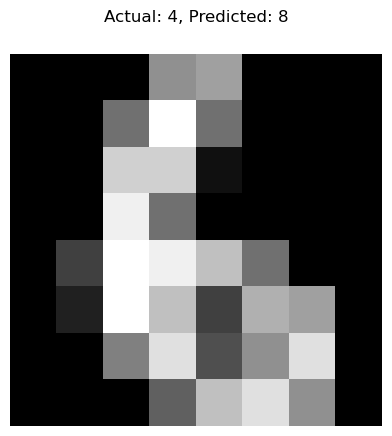

Index: 152, Actual Label: 8, Predicted Label: 1


<Figure size 640x480 with 0 Axes>

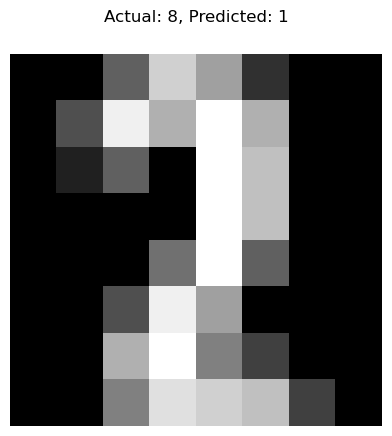

Index: 177, Actual Label: 3, Predicted Label: 7


<Figure size 640x480 with 0 Axes>

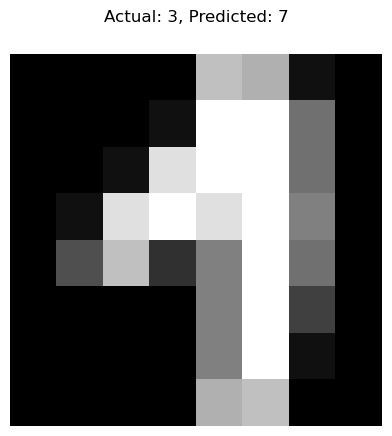

In [16]:
# ... your code here ...

# Evaluate the best classifier on the test set
test_accuracy = best_clf.score(X_test, y_test)
print(f"The best model's test accuracy is: {test_accuracy:.3f}")

# Confusion matrix and visualization
predicted_labels = best_clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()

# Analyzing misclassifications
misclassified = [(i, y_test[i], predicted_labels[i]) for i in range(len(y_test)) if y_test[i] != predicted_labels[i]]
print(f"Number of incorrect predictions: {len(misclassified)}")

for idx, actual, predicted in misclassified:
    print(f"Index: {idx}, Actual Label: {actual}, Predicted Label: {predicted}")
    
    if hasattr(digits, 'images'):
        plt.gray()
        plt.matshow(digits.images[idx])
        plt.title(f"Actual: {actual}, Predicted: {predicted}")
        plt.axis('off')
        plt.show()



## 2. One-class classification (outlier detection)

### 2(a) There is an old gradebook at [http://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt](http://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt).
Use `pd.read_table()` to read it into a DataFrame.

Hint: `pd.read_table()` has many parameters. Check its documentation to find three parameters to:
- Read from the given URL
- Use the separator '\s+', which means 'one or more whitespace characters'
- Skip the first 12 rows, as they are a note to students and not part of the gradebook

In [5]:
# ... your code here ...

df = pd.read_table('http://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt', sep = '\s+', skiprows = 12)
df.head()



,Exam1,Exam2,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,HW6,HW7,HW8,HW9,Percentage,Rank,Percentile,percentageGrade,percentileGrade,Grade
0,121,120,4,4.0,4.0,4.0,4.0,4,4.0,4.0,...,4.0,3.5,3.0,4.0,97.13,391,99.7,A,A,A
1,119,116,4,4.0,4.0,4.0,4.0,4,4.0,4.0,...,4.0,3.5,4.0,3.5,95.22,390,99.5,A,A,A
2,125,109,4,4.0,4.0,4.0,4.0,4,4.0,4.0,...,3.0,4.0,4.0,2.5,94.90,389,99.2,A,A,A
3,117,115,4,4.0,4.0,4.0,4.0,4,4.0,4.0,...,4.0,4.0,3.5,4.0,94.27,387,98.7,A,A,A
4,110,122,4,4.0,4.0,4.0,4.0,4,4.0,4.0,...,4.0,4.0,4.0,4.0,94.27,387,98.7,A,A,A


### 2(b) Use `clf = mixture.GaussianMixture(n_components=1)` to make a one-class Gaussian model to decide which $\mathbf{x}=(\text{Exam1}, \text{Exam2})$ are outliers:

- Set a matrix X to the first two columns, Exam1 and Exam.
- These exams were worth 125 points each. Transform scores to percentages in $[0, 100]$.

  Hint: I tried the MinMaxScaler() first, but it does the wrong thing if there aren't scores
  of 0 and 125 in each column. So, instead, I just multiplied the whole matrix by 100 / 125.
- Fit your classifier to X.
  
  Hint:
  - The reference page for `mixture.GaussianMixture` includes a `fit(X, y=None)` method
    with the comment that y is ignored (as this is an unsupervised learning algorithm--there
    is no $y$) but present for API consistency. So we can fit with just X.
  - I got a warning about "KMeans ... memory leak". You may ignore this
    warning if you see it. I still got satisfactory results.
- Print the center $\mathbf{\mu}$ and covariance matrix $\mathbf{\Sigma}$ from the two-variable
  $N_2(\mathbf{\mu}, \mathbf{\Sigma})$ distribution you estimated.

In [6]:
# ... your code here ...

X = df[['Exam1', 'Exam2']].values * (100 / 125)

# Step 2: Fit a one-class Gaussian model
clf = mixture.GaussianMixture(n_components=1, random_state=0)
clf.fit(X)

# Step 3: Print the mean (μ) and covariance matrix (Σ)
mu = clf.means_[0]
sigma = clf.covariances_[0]

print("Estimated Mean (μ):")
print(mu)
print("\nEstimated Covariance Matrix (Σ):")
print(sigma)


Estimated Mean (μ):
[82.81329923 71.01176471]

Estimated Covariance Matrix (Σ):
[[155.51123078  73.02961336]
 [ 73.02961336 180.87014392]]


### 2(c) Here I have given you code to make a contour plot of the negative log likelihood $-\ln f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ for $\mathbf{X} \sim N_2(\mathbf{\mu}, \mathbf{\Sigma})$, provided you have set `clf`.

```
# make contour plot of log-likelihood of samples from clf.score_samples()
margin = 10
x = np.linspace(0 - margin, 100 + margin)
y = np.linspace(0 - margin, 100 + margin)
grid_x, grid_y = np.meshgrid(x, y)
two_column_grid_x_grid_y = np.array([grid_x.ravel(), grid_y.ravel()]).T
negative_log_pdf_values = -clf.score_samples(two_column_grid_x_grid_y)
grid_z = negative_log_pdf_values
grid_z = grid_z.reshape(grid_x.shape)
plt.contour(grid_x, grid_y, grid_z, levels=10) # X, Y, Z
plt.title('(Exam1, Exam2) pairs')
```

Paste my code into your code cell below and add more code:
- Add black $x$- and $y$- axes. Label them Exam1 and Exam2.
- Plot the data points in blue.
- Plot $\mathbf{\mu}=$ `clf.means_` as a big lime dot.
- Overplot (i.e. plot again) in red the 8 outliers determined by a threshold consisting
  of the 0.02 quantile of the pdf values $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$
  for each $\mathbf{x}$ in X.
  
  Hint: `clf.score_samples(X)` gives log likelihood, so `np.exp(clf.score_samples(X))`
  gives the required $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ values.

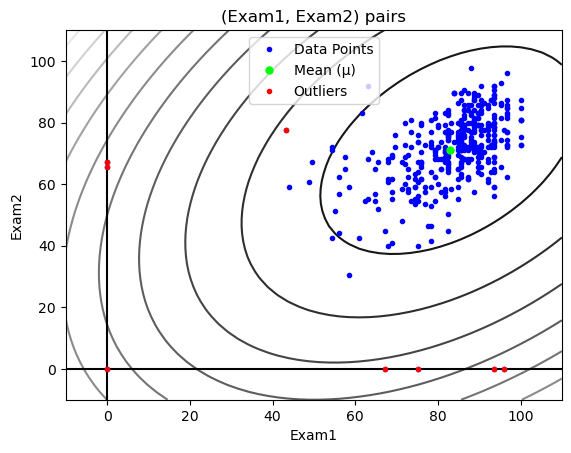

In [7]:
# ... your code here ...


# make contour plot of log-likelihood of samples from clf.score_samples()
margin = 10
x = np.linspace(0 - margin, 100 + margin)
y = np.linspace(0 - margin, 100 + margin)
grid_x, grid_y = np.meshgrid(x, y)
two_column_grid_x_grid_y = np.array([grid_x.ravel(), grid_y.ravel()]).T
negative_log_pdf_values = -clf.score_samples(two_column_grid_x_grid_y)
grid_z = negative_log_pdf_values
grid_z = grid_z.reshape(grid_x.shape)
plt.contour(grid_x, grid_y, grid_z, levels=10) # X, Y, Z
plt.title('(Exam1, Exam2) pairs')



# Label axis and plot data points
plt.plot(np.linspace(start=0, stop=0),y,'black')
plt.plot(x,np.linspace(start=0, stop=0),'black')
plt.xlabel('Exam1')
plt.ylabel('Exam2')

# Plot data points in blue
plt.plot(X[:, 0], X[:, 1], '.b', label='Data Points')

# Plot μ as a lime green dot
plt.plot(clf.means_[0][0], clf.means_[0][1], '.', color='lime', markersize=10, label='Mean (μ)')

# Identify and plot the 8 outliers in red
outliers = X[np.argsort(np.exp(clf.score_samples(X)))[0:8]]
plt.plot(outliers[:, 0], outliers[:, 1], '.r', label='Outliers')

# Add legend and show plot
plt.legend()
plt.show()






### What characterizes 7 of these 8 outliers? Write your answer in a markdown cell.

In [8]:
# ... your English text in a Markdown cell here ...

outliers 

array([[ 0. , 67.2],
       [ 0. , 65.6],
       [ 0. ,  0. ],
       [96. ,  0. ],
       [93.6,  0. ],
       [75.2,  0. ],
       [67.2,  0. ],
       [43.2, 77.6]])

Seven of the eight outliers have at least one exam score of zero.

### 2(d) Write a little code to report whether, by the 0.02 quantile criterion, $\mathbf{x}=$ (Exam1=50, Exam2=100) is an outlier.

Hint: Compare $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ to your threshold

In [9]:
# ... your code here ...

# Define the point x = (Exam1=50, Exam2=100)
point = np.array([[50, 100]])

# Calculate the PDF value for the point
pdf_value = np.exp(clf.score_samples(point))

# Compare the PDF value to the 0.02 quantile threshold
threshold = np.quantile(np.exp(clf.score_samples(X)), 0.02)
is_outlier = pdf_value < threshold


# Report whether the point is an outlier
print(f"The point (Exam1=50, Exam2=100) is an outlier: {is_outlier[0]}")


The point (Exam1=50, Exam2=100) is an outlier: True


## 3. Explore the fact that accuracy can be misleading for imbalanced data.
Here I make a fake imbalanced data set by randomly sampling $y$ from a distribution with $P(y = 0) = 0.980$ and $P(y = 1) = 0.020$.

In [10]:
X, y = make_classification(n_samples=10000, n_classes=2, weights=[0.98, 0.02],
                           n_clusters_per_class=1, flip_y=0.01, random_state=0)
print(f'np.bincount(y)={np.bincount(y)}; we expect about 980 zeros and 20 ones.')
print(f'np.mean(y)={np.mean(y)}; we expect the proportion of ones to be about 0.020.')

np.bincount(y)=[9752  248]; we expect about 980 zeros and 20 ones.
np.mean(y)=0.0248; we expect the proportion of ones to be about 0.020.


Here I split the data into 50% training and 50% testing data.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0, stratify=y)
print(f'np.bincount(y_train)={np.bincount(y_train)}')
print(f'np.mean(y_train)={np.mean(y_train)}.')
print(f'np.bincount(y_test)={np.bincount(y_test)}.')
print(f'np.mean(y_test)={np.mean(y_test)}.')

np.bincount(y_train)=[4876  124]
np.mean(y_train)=0.0248.
np.bincount(y_test)=[4876  124].
np.mean(y_test)=0.0248.


### 3a. Train and assess a gradient boosting model.
- Train on the training data.
- Use 100 trees of maximum depth 1 and learning rate $\alpha = 0.25$.
- Use `random_state=0` (to give us all a chance of getting the same results).
- Display the accuracy, precision, recall, and AUC on the test data. Use 3 decimal places.
  Use a labeled print statement with 3 decimal places so the reader can easily find each metric.
- Make an ROC curve from your classifier and the test data.

Accuracy: 0.982
Precision: 0.846
Recall: 0.355
AUC: 0.783


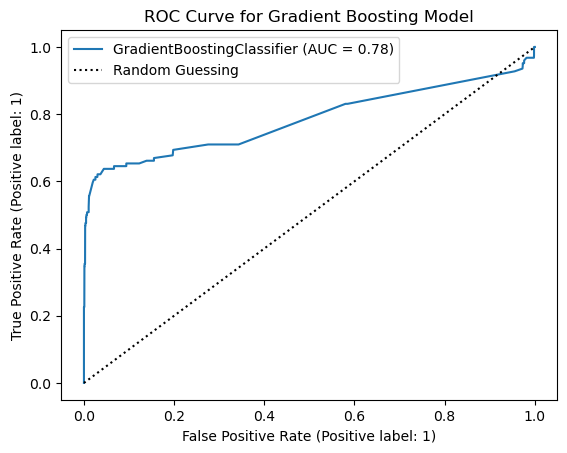

In [12]:
# ... your code here ...

#Train on the training data 

# Train on the training data
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.25, max_depth=1, random_state=0)
clf.fit(X_train, y_train)

# Display the metrics
accuracy = accuracy_score(y_test, clf.predict(X_test))
precision = precision_score(y_test, clf.predict(X_test))
recall = recall_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"AUC: {auc:.3f}")

# Plot the ROC curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.plot([0, 1], [0, 1], ':k', label='Random Guessing')
plt.title('ROC Curve for Gradient Boosting Model')
plt.legend()
plt.show(block=False)


Note the high accuracy but lousy precision, recall, and AUC.

Note that since the data have about 98% $y = 0$, we could get about 98% accuracy
by just always predicting $\hat{y} = 0$. High accuracy alone is not necessarily helpful.

### 3b. Now oversample the data to get a balanced data set.
- Use the `RandomOverSampler(random_state=0)` to oversample only the training data
  and get a balanced training data set.
- Repeat your train/assess block from above. (You should find improved recall thanks to
  more of the $y = 1$ cases being classified correctly, along with improved AUC; at the
  cost of decreased accuracy and precision.)


Model accuracy on test set: 0.875
ROC AUC score: 0.941
Precision: 0.936, Recall: 0.805, Overall Accuracy: 0.875


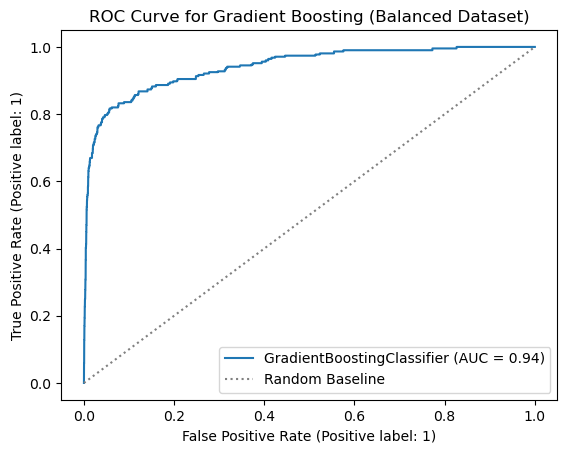

In [13]:
# oversampling to achieve class balance
oversampler = RandomOverSampler(random_state=0)
X_balanced, y_balanced = oversampler.fit_resample(X, y)

#  Split the balanced data into training and testing sets
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balanced, y_balanced, test_size=0.5, random_state=0, stratify=y_balanced
)

#  Train the Gradient Boosting Classifier on the balanced dataset
gradient_boost = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.25, max_depth=1, random_state=0
)
gradient_boost.fit(X_train_bal, y_train_bal)

#  Evaluate the trained model on the test set
y_probs = gradient_boost.predict_proba(X_test_bal)[:, 1]  # Probabilities for the positive class
test_accuracy = gradient_boost.score(X_test_bal, y_test_bal)
roc_auc = roc_auc_score(y_test_bal, y_probs)

print(f"Model accuracy on test set: {test_accuracy:.3f}")
print(f"ROC AUC score: {roc_auc:.3f}")

#  Compute additional metrics for performance evaluation
y_preds = gradient_boost.predict(X_test_bal)
precision = precision_score(y_test_bal, y_preds)
recall = recall_score(y_test_bal, y_preds)
overall_accuracy = accuracy_score(y_test_bal, y_preds)

print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, Overall Accuracy: {overall_accuracy:.3f}")

#  Plot the ROC curve for visualization
RocCurveDisplay.from_estimator(gradient_boost, X_test_bal, y_test_bal)
plt.plot([0, 1], [0, 1], linestyle=":", color="gray", label="Random Baseline")
plt.title("ROC Curve for Gradient Boosting (Balanced Dataset)")
plt.legend()
plt.show(block=False)


Note that we traded a little accuracy for much improved precision, recall, and AUC.

If you do classification in your project and report accuracy, please
also report the proportions of $y = 0$ and $y = 1$ in your test data so that
we get insight into whether your model improves upon always guessing $\hat{y} = 0$
or always guessing $\hat{y} = 1$.